In [0]:
from __future__ import print_function
import os, sys
import logging
import six, csv
import numpy as np
import pandas as pd
import glob
import tqdm

# import matplotlib
# matplotlib.use("AGG")
import matplotlib.pyplot as plt

import pydicom as dicom
import nibabel as nib
import skimage
import SimpleITK as sitk

import radiomics
from radiomics import featureextractor
from radiomics import firstorder, glcm, imageoperations, shape, glrlm, glszm

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
cd "/content/gdrive/My Drive/projects/ClinicAI/FinalProject/"

/content/gdrive/My Drive/projects/ClinicAI/FinalProject


In [4]:
ls

data/                               test-images/
features/                           train_acc.png
feature_selection.ipynb             train-images/
generate_X_image_npz.ipynb          train_loss.png
log/                                train-survival.csv
radiomics_feature_extraction.ipynb  Untitled0.ipynb
radiomics_featureName.npy           vgg_gru.csv
rf_age.csv                          vgg_gru.ipynb
rf.csv                              vgg_lstm.ipynb
rf_sfm2.csv                         X_3.npz
rf_sfm3.csv                         X_radiomicsFeatures.npz
sample_submission.csv               X_test.npz
select_rf_1e_3.joblib               X_test_radiomicsFeatures.npz
select_rf_5e_3.joblib               X_train.npz
sfm3_ANN4_2.csv                     X_vgg.npz
sfm3_ANN4.csv                       y_survival_class.npy
test-age.csv                        y_survival.npy


In [0]:
def load_nii_gz(label_fpath, transpose=False):
    data = nib.load(label_fpath)
    pixel_array = data.get_fdata()
    if transpose:
        pixel_array = np.transpose(pixel_array, axes=(2,1,0))
    return pixel_array 

In [0]:
X = np.load("X_train.npz")
y = np.load("y_survival.npy")

In [6]:
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, Input
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

Using TensorFlow backend.


In [7]:
vgg = VGG16(weights='imagenet', include_top=False)

W0620 04:23:39.921290 140444065990528 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0620 04:23:39.939475 140444065990528 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0620 04:23:39.942502 140444065990528 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0620 04:23:39.969330 140444065990528 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0620 04:23:40.336725 140444065990528 deprecation_wrapp

In [9]:
X["flair"].shape

(39, 155, 240, 240)

In [0]:
# X_3 = np.zeros((39, 155, 240, 240, 3))
# for i in range(39):
#     X_3[i, :, :, :, 0] = X["t1"][i]
#     X_3[i, :, :, :, 1] = X["t1ce"][i]
#     X_3[i, :, :, :, 2] = X["flair"][i]
# #     

# np.savez_compressed("X_3", rgb=X_3)

# X_3 = np.load("X_3.npz")["rgb"][:, 58:98, ...]
X_3_40 = np.load("X_3_40slice.npz")["rgb"]

In [18]:
np.sum(X["seg"][:, :, ...])

6586778

In [20]:
np.sum(X["seg"][:, 58:98, ...])

4008045

In [11]:
X_3_40.shape

(39, 40, 240, 240, 3)

In [0]:
# np.savez_compressed("X_3_40slice", rgb=X_3)

In [14]:
t1_t1ce_flair_vgg = []
for x in tqdm.tqdm(X_3_40):
    x = skimage.transform.resize(x, (40,224,224))
#     x = skimage.color.gray2rgb(x) 
  
    t1_t1ce_flair_vgg.append(vgg.predict(x).reshape(40,-1))
t1_t1ce_flair_vgg = np.array(t1_t1ce_flair_vgg)


100%|██████████| 39/39 [00:57<00:00,  1.48s/it]


In [16]:
t1_t1ce_flair_vgg.shape

(39, 40, 25088)

In [0]:
np.save("vgg_X_3_40slice", t1_t1ce_flair_vgg)

In [0]:
X_vgg_age = np.concatenate((t1_t1ce_flair_vgg.reshape(39,-1), X["age"].reshape(-1,1)), axis = 1)

In [19]:
X_vgg_age.shape

(39, 1003521)

In [0]:
def dnn():
    inputs = Input(shape=(1003521,))
    x = Dense(16, kernel_initializer='normal', activation='relu')(inputs)
    outputs = Dense(1, kernel_initializer='normal')(x)
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(loss='mse', optimizer='adam')
    return model

In [63]:
model = dnn()
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 1003521)           0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)                16056352  
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 17        
Total params: 16,056,369
Trainable params: 16,056,369
Non-trainable params: 0
_________________________________________________________________


In [64]:
history = model.fit(X_vgg_age, y,validation_split=0.25,  epochs=60)

Train on 29 samples, validate on 10 samples
Epoch 1/60
29/29 [==============================] - 1s 27ms/step - loss: 308951.3438 - val_loss: 1540215.3750
Epoch 2/60
29/29 [==============================] - 0s 9ms/step - loss: 1288990.6250 - val_loss: 176536.4688
Epoch 3/60
29/29 [==============================] - 0s 9ms/step - loss: 199596.2656 - val_loss: 336619.0000
Epoch 4/60
29/29 [==============================] - 0s 8ms/step - loss: 254724.5312 - val_loss: 425167.6875
Epoch 5/60
29/29 [==============================] - 0s 9ms/step - loss: 325344.4688 - val_loss: 427151.7500
Epoch 6/60
29/29 [==============================] - 0s 8ms/step - loss: 326347.9375 - val_loss: 392383.5938
Epoch 7/60
29/29 [==============================] - 0s 9ms/step - loss: 295793.1250 - val_loss: 324761.3125
Epoch 8/60
29/29 [==============================] - 0s 9ms/step - loss: 239971.1562 - val_loss: 250074.3438
Epoch 9/60
29/29 [==============================] - 0s 9ms/step - loss: 178772.6875 - val

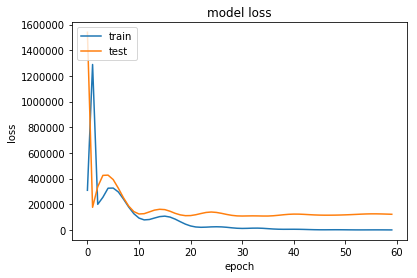

In [65]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('epoch_60_train_loss.png')

In [0]:
model.save("vgg_X_3_40slice.h5")

In [0]:
# t1_vgg = []
# for x in tqdm.tqdm(X["t1"]):
#     x = skimage.transform.resize(x, (155,224,224))
#     x = skimage.color.gray2rgb(x) 
#     t1_vgg.append(vgg.predict(x).reshape(155,-1))
# t1_vgg = np.array(t1_vgg)

100%|██████████| 39/39 [01:07<00:00,  1.72s/it]


In [0]:
# t1ce_vgg = []
# for x in tqdm.tqdm(X["t1ce"]):
#     x = skimage.transform.resize(x, (155,224,224))
#     x = skimage.color.gray2rgb(x) 
#     t1ce_vgg.append(vgg.predict(x).reshape(155,-1))
# t1ce_vgg = np.array(t1ce_vgg)

100%|██████████| 39/39 [01:07<00:00,  1.73s/it]


In [0]:
# t2_vgg = []
# for x in tqdm.tqdm(X["t2"]):
#     x = skimage.transform.resize(x, (155,224,224))
#     x = skimage.color.gray2rgb(x) 
#     t2_vgg.append(vgg.predict(x).reshape(155,-1))
# t2_vgg = np.array(t2_vgg)

100%|██████████| 39/39 [01:07<00:00,  1.72s/it]


In [0]:
# np.savez_compressed("X_vgg.npz", t1=t1_vgg, t1ce=t1ce_vgg, t2=t2_vgg, flair=flair_vgg)

In [0]:
# X_vgg = np.load("X_vgg.npz")

In [0]:
from keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, \
                             verbose=2, mode='auto', baseline=None, restore_best_weights=False)

In [0]:
test_image_folder = "./test-images/image/"

sample_submission = np.genfromtxt('./sample_submission.csv', 
                                  delimiter=',', 
                                  dtype='str',
                                  skip_header = 1)
test_encode_list = sample_submission[:, 0]

In [0]:
X_test=np.load("X_test.npz")X

In [33]:
X_test["t1"][0][58:98].shape

(40, 240, 240)

In [0]:
X_test_3 = np.zeros((20,40,240,240,3))
for i in range(20):
    X_test_3[i, :, :, :, 0] = X_test["t1"][i][58:98]
    X_test_3[i, :, :, :, 1] = X_test["t1ce"][i][58:98]
    X_test_3[i, :, :, :, 2] = X_test["flair"][i][58:98]


In [0]:
np.save("X_test_3_vgg_40slice", X_test_3)

In [38]:
X_test_vgg = []
for x in tqdm.tqdm(X_test_3):
    x = skimage.transform.resize(x, (40,224,224))
#     x = skimage.color.gray2rgb(x) 
  
    X_test_vgg.append(vgg.predict(x).reshape(40,-1))
X_test_vgg = np.array(X_test_vgg)


100%|██████████| 20/20 [00:29<00:00,  1.47s/it]


In [70]:
X_test_vgg.shape

(20, 40, 25088)

In [0]:
np.save("X_test_3_vgg_40slice", X_test_vgg)

In [41]:
X_test_vgg_age = np.concatenate((X_test_vgg.reshape(20, -1), X_test["age"].reshape(-1,1)), axis = 1)
X_test_vgg_age.shape

(20, 1003521)

In [0]:
# test_X_flair = np.zeros((len(test_encode_list), 155, 240, 240))

# for i, encode in enumerate(test_encode_list):
#     test_X_flair[i, :, :, :] = load_nii_gz(os.path.join(test_image_folder, encode, 'flair.nii.gz'), transpose=True)

In [0]:
# test_flair = []
# for x in test_X_flair:
#     x = skimage.transform.resize(x, (155,224,224))
#     x = skimage.color.gray2rgb(x) 
#     test_flair.append(vgg.predict(x).reshape(155,-1))
# test_X_flair = np.array(test_flair)

In [0]:
test_preds = model.predict(X_test_vgg_age)

In [67]:
test_preds

array([[392.77155],
       [453.4411 ],
       [450.27405],
       [224.90176],
       [456.25537],
       [420.07434],
       [463.77603],
       [506.6046 ],
       [385.83734],
       [563.6962 ],
       [502.14786],
       [612.3937 ],
       [473.67316],
       [229.67667],
       [352.34595],
       [358.07913],
       [475.76318],
       [587.761  ],
       [479.6666 ],
       [669.27826]], dtype=float32)

In [44]:
solution_path = './X_3_vgg.csv'
with open(solution_path, 'w') as f:
    f.write('Encode,Survival\n')
    for i, encode in enumerate(test_encode_list):
        print(encode, test_preds[i][0]) 
        f.write(encode + ',' + str(test_preds[i][0]) + '\n')

4zqmljfrc675dtrky3gchyx87jkl3czk 379.0725
t6if2ohjnd7mh06z81wwd3sp86h427ad 351.4942
7rmkmfclt0mkmqs5b3e6rny5hwgwo11y 372.14703
chjxxykw2lz1v37hgriyniblgi41d5y3 269.1935
orhcxlyoc0x6idbzlqmbsdqduehdy75o 405.54733
7rxxiwwbbxy0yoatpsyltln3v2wtne9e 378.58597
0r3e6ezursuo5y6m3jwpztq763cjki0p 471.2116
haz4ax59boce4twwwpzfq7hwydgqn9we 461.15714
zcn7u2kqbrqlzgf07yzzjg5mqyqgqul1 447.88727
27w6sraww3g2ui9fxpu08tcgyocprtqg 466.4291
sedxnmxte7gxrdbbpx8p8b3jhurlrx3n 464.3841
ji97woc3vcyn9lzq5xfpk3j95i5vswmm 519.88495
09amv752acxnzvkfughexk0wilhxdtd5 455.8058
gg4o6f2xyb2zpclttmjy35lqnasg9vz4 256.87442
hjhau2e5j5p1zpwbbuocjiwplq20l2dz 337.90936
2398n5c5yz5km503of24gbxdb803gq5q 326.8255
do2ausaft9rrqogh8y16qb0vuy5roywm 455.54834
tspn2x2dggh1ugi1vizmvcrsll644p2a 626.4467
djquj44l7imhygd741v81p9gfc4nu5xk 533.6412
jbhvvv6rpu7mbs5bpu1byb31c9yzo9db 669.70935


In [56]:
solution_path = './X_3_vgg_epoch55.csv'
with open(solution_path, 'w') as f:
    f.write('Encode,Survival\n')
    for i, encode in enumerate(test_encode_list):
        print(encode, test_preds[i][0]) 
        f.write(encode + ',' + str(test_preds[i][0]) + '\n')

4zqmljfrc675dtrky3gchyx87jkl3czk 367.02887
t6if2ohjnd7mh06z81wwd3sp86h427ad 285.00354
7rmkmfclt0mkmqs5b3e6rny5hwgwo11y 278.04495
chjxxykw2lz1v37hgriyniblgi41d5y3 291.00278
orhcxlyoc0x6idbzlqmbsdqduehdy75o 318.60638
7rxxiwwbbxy0yoatpsyltln3v2wtne9e 389.34503
0r3e6ezursuo5y6m3jwpztq763cjki0p 372.6074
haz4ax59boce4twwwpzfq7hwydgqn9we 368.68564
zcn7u2kqbrqlzgf07yzzjg5mqyqgqul1 311.74
27w6sraww3g2ui9fxpu08tcgyocprtqg 473.90564
sedxnmxte7gxrdbbpx8p8b3jhurlrx3n 469.21432
ji97woc3vcyn9lzq5xfpk3j95i5vswmm 393.05356
09amv752acxnzvkfughexk0wilhxdtd5 306.6543
gg4o6f2xyb2zpclttmjy35lqnasg9vz4 261.5331
hjhau2e5j5p1zpwbbuocjiwplq20l2dz 357.36105
2398n5c5yz5km503of24gbxdb803gq5q 394.48413
do2ausaft9rrqogh8y16qb0vuy5roywm 319.84988
tspn2x2dggh1ugi1vizmvcrsll644p2a 648.94476
djquj44l7imhygd741v81p9gfc4nu5xk 408.36612
jbhvvv6rpu7mbs5bpu1byb31c9yzo9db 539.0989


In [62]:
solution_path = './X_3_vgg_epoch30.csv'
with open(solution_path, 'w') as f:
    f.write('Encode,Survival\n')
    for i, encode in enumerate(test_encode_list):
        print(encode, test_preds[i][0]) 
        f.write(encode + ',' + str(test_preds[i][0]) + '\n')

4zqmljfrc675dtrky3gchyx87jkl3czk 348.86548
t6if2ohjnd7mh06z81wwd3sp86h427ad 489.17563
7rmkmfclt0mkmqs5b3e6rny5hwgwo11y 454.9816
chjxxykw2lz1v37hgriyniblgi41d5y3 373.38776
orhcxlyoc0x6idbzlqmbsdqduehdy75o 496.53494
7rxxiwwbbxy0yoatpsyltln3v2wtne9e 408.56107
0r3e6ezursuo5y6m3jwpztq763cjki0p 558.4732
haz4ax59boce4twwwpzfq7hwydgqn9we 473.71948
zcn7u2kqbrqlzgf07yzzjg5mqyqgqul1 423.5494
27w6sraww3g2ui9fxpu08tcgyocprtqg 512.49426
sedxnmxte7gxrdbbpx8p8b3jhurlrx3n 583.738
ji97woc3vcyn9lzq5xfpk3j95i5vswmm 698.3829
09amv752acxnzvkfughexk0wilhxdtd5 554.6434
gg4o6f2xyb2zpclttmjy35lqnasg9vz4 356.29623
hjhau2e5j5p1zpwbbuocjiwplq20l2dz 370.0032
2398n5c5yz5km503of24gbxdb803gq5q 417.52155
do2ausaft9rrqogh8y16qb0vuy5roywm 449.97787
tspn2x2dggh1ugi1vizmvcrsll644p2a 559.6915
djquj44l7imhygd741v81p9gfc4nu5xk 540.06085
jbhvvv6rpu7mbs5bpu1byb31c9yzo9db 680.2289


In [68]:
solution_path = './X_3_vgg_epoch60.csv'
with open(solution_path, 'w') as f:
    f.write('Encode,Survival\n')
    for i, encode in enumerate(test_encode_list):
        print(encode, test_preds[i][0]) 
        f.write(encode + ',' + str(test_preds[i][0]) + '\n')

4zqmljfrc675dtrky3gchyx87jkl3czk 392.77155
t6if2ohjnd7mh06z81wwd3sp86h427ad 453.4411
7rmkmfclt0mkmqs5b3e6rny5hwgwo11y 450.27405
chjxxykw2lz1v37hgriyniblgi41d5y3 224.90176
orhcxlyoc0x6idbzlqmbsdqduehdy75o 456.25537
7rxxiwwbbxy0yoatpsyltln3v2wtne9e 420.07434
0r3e6ezursuo5y6m3jwpztq763cjki0p 463.77603
haz4ax59boce4twwwpzfq7hwydgqn9we 506.6046
zcn7u2kqbrqlzgf07yzzjg5mqyqgqul1 385.83734
27w6sraww3g2ui9fxpu08tcgyocprtqg 563.6962
sedxnmxte7gxrdbbpx8p8b3jhurlrx3n 502.14786
ji97woc3vcyn9lzq5xfpk3j95i5vswmm 612.3937
09amv752acxnzvkfughexk0wilhxdtd5 473.67316
gg4o6f2xyb2zpclttmjy35lqnasg9vz4 229.67667
hjhau2e5j5p1zpwbbuocjiwplq20l2dz 352.34595
2398n5c5yz5km503of24gbxdb803gq5q 358.07913
do2ausaft9rrqogh8y16qb0vuy5roywm 475.76318
tspn2x2dggh1ugi1vizmvcrsll644p2a 587.761
djquj44l7imhygd741v81p9gfc4nu5xk 479.6666
jbhvvv6rpu7mbs5bpu1byb31c9yzo9db 669.27826
